In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Import packages
import pandas as pd
import numpy as np
from sklearn.metrics import *
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.preprocessing import QuantileTransformer
import scipy.stats as sci
import sklearn
from sklearn.model_selection import GridSearchCV
import os

# Custom functions
from plot_mean_foehn_conditions import calculate_stability, plot_mean_foehn_condition_for_one_model, generate_coordinates_from_feature_label
from utils import *
from model_training import *

# Import constants from constants.py file in directory above
import sys
sys.path.append("..")
from constants import *

# Define plotting style
sns.set_style("whitegrid")
sns.set_palette("deep")
plt.rcParams.update({'font.size': 20, 'figure.figsize': (16,9)})

--- Avaliable variables ---
Base directory: BASE_DIR
Month names: MONTH_NAMES
Bounding box coordinates: LON_MIN, LON_MAX, LAT_MIN, LAT_MAX
ERAI coordinates: LONS_ERA, LATS_ERA
CESM coordinates: LONS_CESM, LATS_CESM
CESM slice: INDEX_CESM
CESM coordinates for plotting (string): LONS_CESM_STRING, LATS_CESM_STRING


# Read ERA data

In [4]:
df_ERA_raw = pd.read_csv(os.path.join(BASE_DIR, "data/MeteorologicalData/ERAI_data.csv.gz"), parse_dates=["date"])

In [5]:
df_ERA = df_ERA_raw.copy() # Keep copy of original data

# Load CESM data 

In [6]:
df_CESMp = load_CESM(os.path.join(BASE_DIR, "data/MeteorologicalData/CESM_present_day.csv.gz"), LATS_CESM_STRING=LATS_CESM_STRING, LONS_CESM_STRING=LONS_CESM_STRING)
CESMp_features = set(df_CESMp.columns)

In [7]:
df_CESMf = load_CESM(os.path.join(BASE_DIR, "data/MeteorologicalData/CESM_future_day.csv.gz"), LATS_CESM_STRING=LATS_CESM_STRING, LONS_CESM_STRING=LONS_CESM_STRING)
CESMf_features = set(df_CESMf.columns)

# Use only features which are also in CESM and which are not in the Alps

In [8]:
# Only allow features which also exist in CESM
intersecting_features = list(CESMp_features.intersection(CESMf_features).intersection(set(df_ERA.columns)))
df_ERA = df_ERA[intersecting_features]

In [9]:
# Drop features which are within the Alps (since we want to classify synoptic situation)
lat_features_to_cut = set(df_ERA.loc[0:1,:].filter(regex=("\w+(4570|4664|4759)\w+")).columns)
lon_features_to_cut = set(df_ERA.loc[0:1,:].filter(regex=("\w+(500|625|750|875|1000|1125|1250)\w+")).columns)
intersecting_features = lat_features_to_cut.intersection(lon_features_to_cut)
df_ERA.drop(intersecting_features, axis=1, inplace=True)
print(df_ERA.shape)

(57952, 1099)


# Calculate derived variables in ERAI

In [10]:
# Create potential temperature features
df_PHIT_900 = calc_pot_temp(T=df_ERA.filter(regex=("T_\w+900"))+273.15, p=900.0).add_prefix("PHI")
df_PHIT_850 = calc_pot_temp(T=df_ERA.filter(regex=("T_\w+850"))+273.15, p=850.0).add_prefix("PHI")
df_PHIT_700 = calc_pot_temp(T=df_ERA.filter(regex=("T_\w+700"))+273.15, p=700.0).add_prefix("PHI")
df_ERA = pd.concat([df_ERA, df_PHIT_900, df_PHIT_850, df_PHIT_700], axis=1)

In [11]:
# Sealevel pressure differences
df_SLP_diff = calculate_horizontal_feature_differences(df=df_ERA, variable="SLP", pressure_levels=["sealevel"])

# Geopotential height differences
df_Z_diff = calculate_horizontal_feature_differences(df=df_ERA, variable="Z", pressure_levels=["850", "700"])

# Potential temperature differences
df_PHIT_diff = calculate_horizontal_feature_differences(df=df_ERA, variable="PHIT", pressure_levels=["850"])

# Calculate stability
df_stability = calculate_stability(df_ERA, lats=LATS_CESM_STRING, lons=LONS_CESM_STRING)

# Filter wind velocities
df_wind = df_ERA.filter(regex=("(U|V)\w+")).copy()

In [12]:
# Concat everything
df_ERA = pd.concat([df_ERA["date"], 
                     df_SLP_diff, 
                     df_Z_diff, 
                     df_PHIT_diff, 
                     df_stability, 
                     df_wind], 
                    axis = 1)

# Merge in foehn data at specified location

In [13]:
# Specify location of interest
location="LUG"
foehn_type={"ALT": "SouthFoehn", "LUG": "NorthFoehn"}

In [14]:
# Read foehn preprocessed foehn data from this location
df_foehn_raw = pd.read_csv(os.path.join(BASE_DIR, f"data/FoehnData/{location}_foehn.csv"), parse_dates=["date"])
df_foehn_raw.dropna(inplace=True, how="any", axis=0)

In [15]:
# Merge ERAI and foehn data
df_ERA_all_features = pd.merge(df_foehn_raw, df_ERA, on="date", how="inner")

# Train Model on full data

In [16]:
# Create train and test mask
test_mask = (df_ERA_all_features["date"]>np.datetime64("1991-01-01 00:00")) & (df_ERA_all_features["date"]<np.datetime64("2000-12-31 23:00"))
train_mask = (test_mask == False)

In [17]:
# Create list of all features for prediction
feature_names=df_ERA_all_features.columns.tolist()
feature_names.remove("date")
feature_names.remove("Foehn")

Started
Best threshold: 0.8997067213058472
[[13585   181]
 [  181   589]]
Accuracy: 0.9750963126031921
Precision: 0.7649350649350649
Recall: 0.7649350649350649
ROC-AUC: 0.9892102884765968
Log-Loss: 0.10299481433304883


,feature_name,importance
0,diff_Z_4570_1375_850_Z_4664_375_850,0.397992
1,diff_SLP_4476_1375_sealevel_SLP_4853_750_sealevel,0.070325
2,diff_SLP_4476_1125_sealevel_SLP_4853_875_sealevel,0.031019
3,diff_PHIT_4476_875_850_PHIT_4853_1000_850,0.029693
4,diff_SLP_4570_1375_sealevel_SLP_4853_875_sealevel,0.028117
5,diff_Z_4382_1000_700_Z_4664_375_700,0.026014
6,diff_SLP_4476_1375_sealevel_SLP_4853_875_sealevel,0.023803
7,diff_SLP_4476_1250_sealevel_SLP_4853_875_sealevel,0.014157
8,DELTAPHI_4947_750_700,0.010696
9,V_4476_1000_700,0.010125


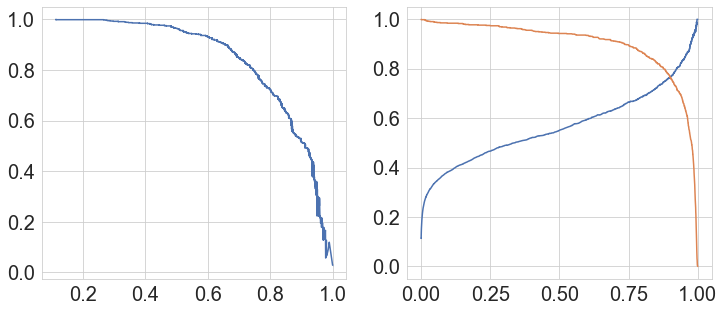

In [1056]:
# Fit a global classifier on all features
model_xg = xgb.XGBClassifier(
                    max_depth=4,
                    learning_rate=0.1,
                    gamma=0.0,
                    min_child_weight=0.0,
                    max_delta_step=0.0,
                    subsample=1.0,
                    colsample_bytree=1.0,
                    colsample_bylevel=1.0,
                    reg_alpha=1.0,
                    reg_lambda=10.0,
                    n_estimators=200,
                    verbosity=0,
                    nthread=25,
                    scale_pos_weight=20.0,
                    base_score=0.05,
                    seed=1337,
                    missing=None,
                  )

params = {"n_estimators": [50,100,200], 'max_depth': [4,5], 'learning_rate': [0.1, 0.2], "reg_alpha": [1], "reg_lambda":[10,100]}
df_ERA_feature_importances = fit_model_and_obtain_importances(model_xg, df_ERA_all_features, feature_names, train_mask, test_mask, with_CV=False, parameters_CV=params)

# Reduce dataframe to most important features (use this as restart files after training large models)

In [1226]:
# Write most important 250 features to text file
feature_names_reduced = list(df_ERA_feature_importances.loc[:250, "feature_name"])
with open(f"reduced_features_{foehn_type[location]}.txt", "w") as f:
    for feature in feature_names_reduced:
        f.write('%s\n' % feature)

In [18]:
# Read most important 250 features from text file
# Only run this cell when large model has been trained
feature_names_reduced = []
with open(os.path.join(BASE_DIR, f"data/reduced_features_{foehn_type[location]}.txt"), 'r') as f:
    for line in f:
        feature_names_reduced.append(line[:-1])

# Build dataframe from reduced features
df_ERA_reduced_features = df_ERA_all_features.loc[:,feature_names_reduced]
df_ERA_reduced_features["date"] = df_ERA_all_features["date"]
df_ERA_reduced_features["Foehn"] = df_ERA_all_features["Foehn"]

# Transform features to quantiles on ERA

In [19]:
# Fit quantile transformer to train set
quantile_scaler_ERA = QuantileTransformer(subsample=10**(6), random_state=42)
quantile_scaler_ERA.fit(df_ERA_reduced_features.loc[train_mask, feature_names_reduced]) # Only fit on training data

# Transform train and test set
df_ERA_reduced_features_scaled = pd.DataFrame(quantile_scaler_ERA.transform(df_ERA_reduced_features.loc[:, feature_names_reduced]), columns = feature_names_reduced, index=df_ERA_reduced_features.index)

# Append date and foehn column
df_ERA_reduced_features_scaled["date"] = df_ERA_all_features["date"]
df_ERA_reduced_features_scaled["Foehn"] = df_ERA_all_features["Foehn"]

# Generate and preprocess CESM features

In [20]:
# Create features from large CESM files which are used by the simplified model
df_CESMp_reduced_features = generate_reduced_features_on_CESM(feature_to_generate = feature_names_reduced, df_CESM = df_CESMp)
df_CESMf_reduced_features = generate_reduced_features_on_CESM(feature_to_generate = feature_names_reduced, df_CESM = df_CESMf)

In [21]:
# Transform CESM features to quantiles. 
quantile_scaler_CESM = QuantileTransformer(subsample=10**(6), random_state=42)
quantile_scaler_CESM.fit(df_CESMp_reduced_features.loc[:, feature_names_reduced]) # Fit transformer to present day data

# Apply transformation to present and future day data
df_CESMp_reduced_features_scaled = pd.DataFrame(quantile_scaler_CESM.transform(df_CESMp_reduced_features.loc[:, feature_names_reduced]), columns = feature_names_reduced, index=df_CESMp_reduced_features.index)
df_CESMf_reduced_features_scaled = pd.DataFrame(quantile_scaler_CESM.transform(df_CESMf_reduced_features.loc[:, feature_names_reduced]), columns = feature_names_reduced, index=df_CESMf_reduced_features.index)

# Append date and ensemble member again
df_CESMp_reduced_features_scaled["date"] = df_CESMp_reduced_features["date"]
df_CESMf_reduced_features_scaled["date"] = df_CESMf_reduced_features["date"]
df_CESMp_reduced_features_scaled["ensemble"] = df_CESMp_reduced_features["ensemble"]
df_CESMf_reduced_features_scaled["ensemble"] = df_CESMf_reduced_features["ensemble"]

# Fit XGBoost to reduced feature set & evaluate

In [22]:
# Train constraint model (parameters were found after hyperparameter optimization in a seperate experiment).
if location=="ALT":
    params = {'max_depth': 4, 'learning_rate': 0.2, "reg_alpha":1, "reg_lambda":20, "n_jobs": 25,"verbosity":1, "seed": 0}
    initial_boosting_rounds = 10
elif location=="LUG":
    params = {'max_depth': 4, 'learning_rate': 0.25, "reg_alpha":1, "reg_lambda":20, "n_jobs": 25,"verbosity":1, "seed": 0}
    initial_boosting_rounds = 20

constrained_xgboost = ConstrainedXGBoost(df_ERA = df_ERA_reduced_features_scaled, 
                                         df_CESMp = df_CESMp_reduced_features_scaled,
                                         features = feature_names_reduced, 
                                         train_mask = train_mask, 
                                         test_mask = test_mask, 
                                         params = params, 
                                         initial_boosting_rounds = initial_boosting_rounds) 
for month in range(1,12+1):
    print(MONTH_NAMES[month-1])
    constrained_xgboost.fit_for_month(month)
    constrained_xgboost.evaluate_for_month(month)

Loading data ...
Fitting global model ...
Storing global model ...
Model ready to use ...
Jan
Best threshold: 0.5532563924789429
Precision: 0.6923076923076923
Recall: 0.6923076923076923
[[1154   20]
 [  20   45]]
Feb
Best threshold: 0.48840922117233276
Precision: 0.7156862745098039
Recall: 0.7156862745098039
[[1001   29]
 [  29   73]]
Mar
Best threshold: 0.5765091180801392
Precision: 0.7440476190476191
Recall: 0.7440476190476191
[[1029   43]
 [  43  125]]
Apr
Best threshold: 0.5577137470245361
Precision: 0.7064220183486238
Recall: 0.7064220183486238
[[1059   32]
 [  32   77]]
May
Best threshold: 0.5614534020423889
Precision: 0.7638888888888888
Recall: 0.763888888888889
[[1151   17]
 [  17   55]]
Jun
Best threshold: 0.5195875763893127
Precision: 0.6721311475409836
Recall: 0.6721311475409836
[[1119   20]
 [  20   41]]
Jul
Best threshold: 0.3429735004901886
Precision: 0.6578947368421053
Recall: 0.6578947368421053
[[1138   26]
 [  26   50]]
Aug
Best threshold: 0.5465162396430969
Precision:

[[13392.   277.]
 [  277.   665.]]
Accuracy: 0.9620833618506605
Precision: 0.7059447983014862
Recall: 0.7059447983014862
ROC-AUC: 0.9807875740960181
Log-Loss: 0.0913124394761063
Saved figure ats: /net/litho/atmosdyn2/chmony/develop/FoehnDevelopment/figures/monthly_scores_ERAI_NorthFoehn.pdf


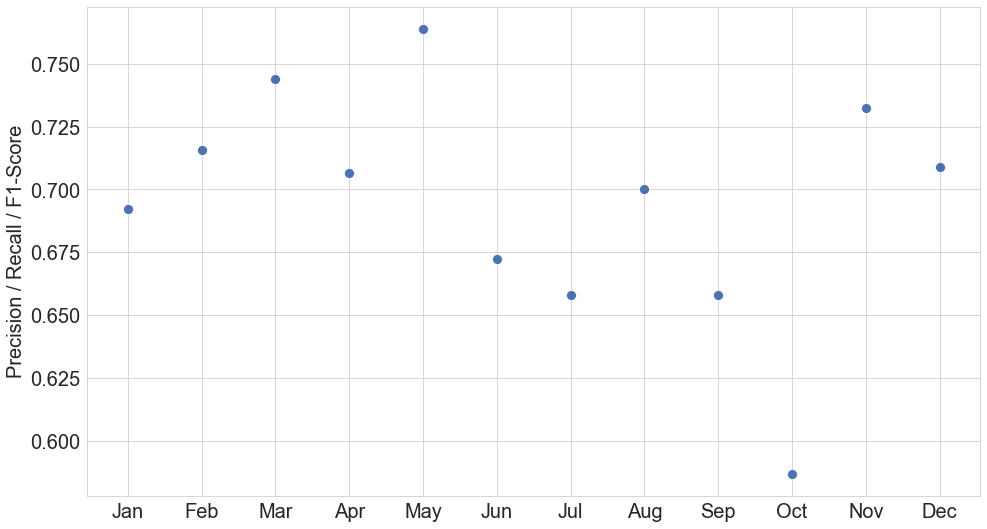

In [29]:
# Evaluate model for all months on test set
tcm = constrained_xgboost.total_confusion_matrix

# Print various test set metrics
print(tcm)
print(f'Accuracy: {(tcm[1,1]+tcm[0,0])/tcm[:,:].sum()}')
print(f'Precision: {tcm[1,1]/tcm[:,1].sum()}')
print(f'Recall: {tcm[1,1]/tcm[1,:].sum()}')
print(f'ROC-AUC: {roc_auc_score(constrained_xgboost.df_ERA.loc[test_mask, "Foehn"], constrained_xgboost.df_ERA.loc[test_mask, "prediction_proba"])}')
print(f'Log-Loss: {log_loss(constrained_xgboost.df_ERA.loc[test_mask, "Foehn"], constrained_xgboost.df_ERA.loc[test_mask, "prediction_proba"])}')

# Plot precision, recall, and f1 scores each month
sns.scatterplot(MONTH_NAMES, list(constrained_xgboost.precision_scores.values()), s=100, alpha=1, marker="o")
# sns.scatterplot(MONTH_NAMES, list(constrained_xgboost.recall_scores.values()), s=100, alpha=1)
# sns.scatterplot(MONTH_NAMES, list(constrained_xgboost.f1_scores.values()), s=100, alpha=1)
plt.ylabel("Precision / Recall / F1-Score")

save_figure(f"monthly_scores_ERAI_{foehn_type[location]}")

# Predict on CESMp and CESMf

In [41]:
df_ERA_reduced_features_scaled = constrained_xgboost.df_ERA
df_CESMp_reduced_features_scaled = constrained_xgboost.predict_for_all_months(df_CESMp_reduced_features_scaled)
df_CESMf_reduced_features_scaled = constrained_xgboost.predict_for_all_months(df_CESMf_reduced_features_scaled)

# Concenate all dataframes

In [42]:
df_foehn_ERA_CESMp_CESMf = create_stacked_dataframe(df_ERA_reduced_features_scaled, df_CESMp_reduced_features_scaled, df_CESMf_reduced_features_scaled)

In [69]:
# Group dataframe by dataset and calculate predictions mean
df_foehn_ERA_CESMp_CESMf[["dataset", "prediction"]].groupby(["dataset"], axis=0, as_index=False).mean()

,dataset,prediction
0,CESMf,0.057025
1,CESMp,0.057579
2,ERA,0.065800
3,observed_foehn,0.065800


95% quantile (CESM-p ensembles):  0.06457534246575342


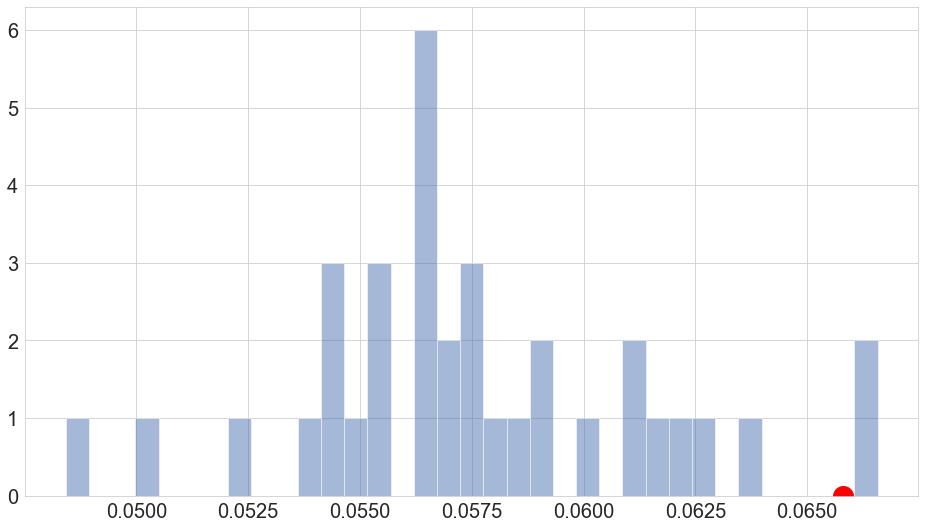

In [97]:
# Group dataframe by dataset & ensemble and calculate predictions mean
df_absolute_test = df_foehn_ERA_CESMp_CESMf[["dataset", "ensemble", "year", "prediction"]].groupby(["dataset", "ensemble"], axis=0, as_index=False).mean()
print("95% quantile (CESM-p ensembles): ", df_absolute_test.loc[df_absolute_test["dataset"]=="CESMp", "prediction"].quantile(0.95))
df_absolute_test.loc[df_absolute_test["dataset"]=="CESMp", "prediction"].hist(bins=35, alpha=0.5)
plt.plot(df_absolute_test.loc[df_absolute_test["dataset"]=="ERA", "prediction"],0,  "ro", markersize=20)  # Plot ERAI mean

In [71]:
# Group dataframe by dataset, ensemble, year, month, and prediction and calculate mean
df_monthly_mean = df_foehn_ERA_CESMp_CESMf[["year", "month", "dataset", "ensemble", "prediction"]].groupby(["dataset", "ensemble", "year", "month"], axis=0, as_index=False).mean()

In [72]:
# Retrieve the test period (1991 until 2000) and future prediction (2091-2100)
test_mask_final_plot = ((1990<df_monthly_mean["year"]) & (df_monthly_mean["year"]<2001)) | (2090<df_monthly_mean["year"])
df_monthly_mean_testset = df_monthly_mean[test_mask_final_plot]

# Create Plots

Saved figure at: /net/litho/atmosdyn2/chmony/develop/FoehnDevelopment/figures/final_comparison_NorthFoehn.pdf


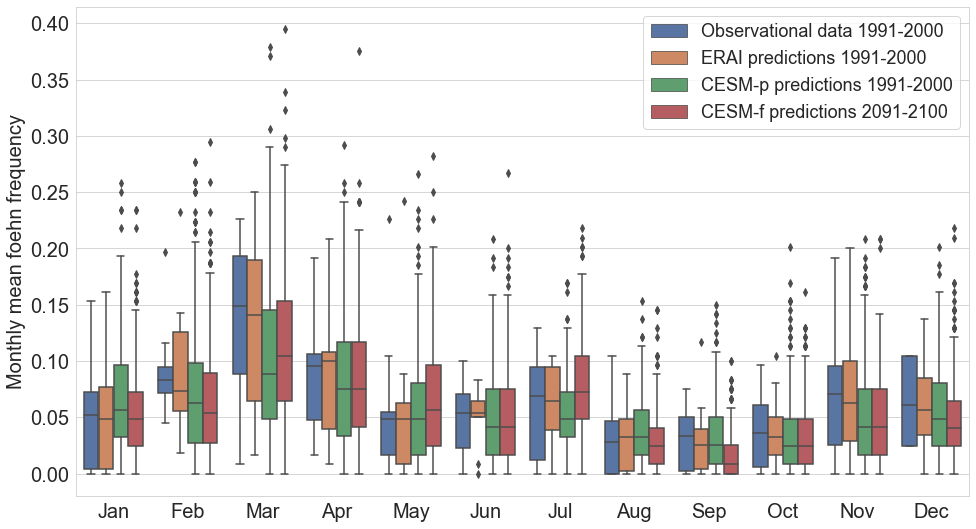

In [75]:
# Plot boxplot for mean foehn frequencies for all datasets
fig = sns.boxplot(x="month", y="prediction", data=df_monthly_mean_testset, hue="dataset", hue_order=["observed_foehn", "ERA", "CESMp", "CESMf"])
fig.set_xticklabels(MONTH_NAMES)
plt.xlabel("")
plt.ylabel("Monthly mean foehn frequency")

handles, labels = fig.get_legend_handles_labels()
labels = ["Observational data 1991-2000", "ERAI predictions 1991-2000", "CESM-p predictions 1991-2000", "CESM-f predictions 2091-2100" ]
fig.legend(handles, labels, fontsize=18)
save_figure(f"final_comparison_{foehn_type[location]}")

# Second statistical test

Saved figure at: /net/litho/atmosdyn2/chmony/develop/FoehnDevelopment/figures/statistical_test_ERAI_CESMp_NorthFoehn.pdf


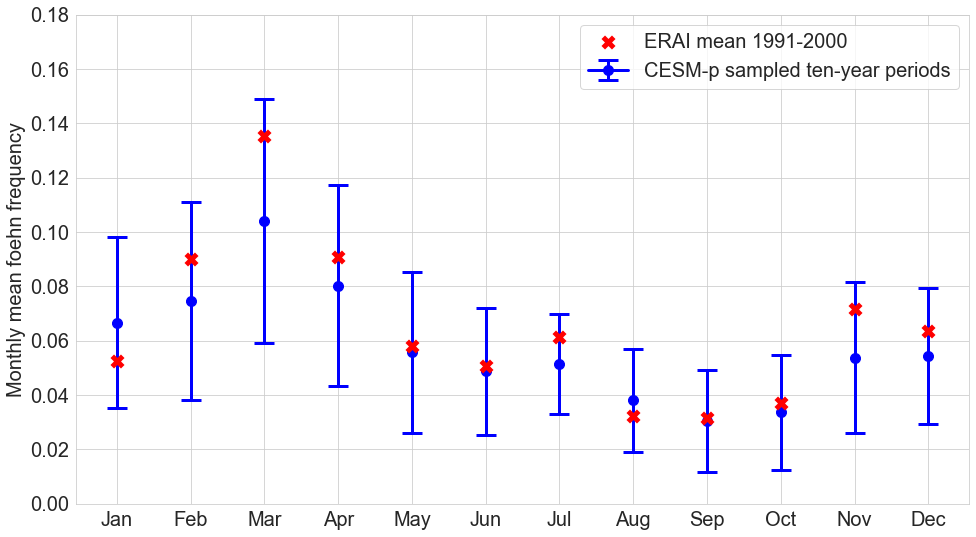

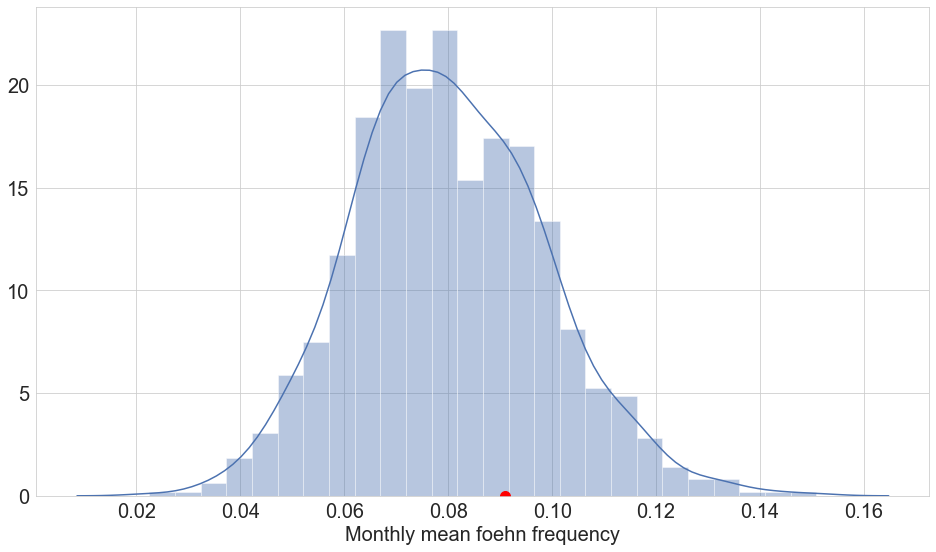

In [90]:
ax = plt.axes()

# Loop over all months
for month_test in range(1, 12+1):
    
    # Draw monthly foehn means for a given month for potential CESM periods (1991-2000)
    CESM_test_distribution = []
    df_CESMp_monthly = df_monthly_mean_testset.loc[(df_monthly_mean_testset["dataset"]=="CESMp") & (df_monthly_mean_testset["month"]==month_test),:].reset_index()
    for i in range(1000):  # Draw 1000 potential realizations
        CESM_test_distribution_year = []
        for year in range(1991, 2001):
            CESM_test_distribution_year.append(df_CESMp_monthly.loc[df_CESMp_monthly["year"]==year, "prediction"].sample(1))  # Randomly pick a month out of the 35 ensemble members
        CESM_test_distribution.append(np.mean(CESM_test_distribution_year))
    
    # Plot CESM distribution (mean and second standart deviation)
    plt.figure(1)
    plt.errorbar(month_test, np.mean(np.array(CESM_test_distribution)), 
                 yerr = 2*np.array(CESM_test_distribution).std(), 
                 color="b", 
                 marker="o",
                 markersize=10, 
                 linewidth=3, 
                 capsize=10, 
                 capthick=3, 
                 zorder=1)
    
    # Plot ERAI mean
    plt.scatter(month_test, (df_monthly_mean_testset.loc[(df_monthly_mean_testset["dataset"]=="ERA") & (df_monthly_mean_testset["month"]==month_test), "prediction"]).mean(), 
                marker="x", 
                color="r", 
                s=110, 
                linewidth=5, 
                zorder=10)
    
    # Plot histogram of CESM distribution for a selected month
    if month_test==4:
        plt.figure()
        sns.distplot(CESM_test_distribution)
        plt.plot(df_monthly_mean_testset.loc[(df_monthly_mean_testset["dataset"]=="ERA") & (df_monthly_mean_testset["month"]==month_test), "prediction"].mean(),0, 
                "ro", 
                markersize=10)
        plt.xlabel("Monthly mean foehn frequency")
    
    if month_test==1:  # To make plot prettier
        legend = ax.legend(["ERAI mean 1991-2000", "CESM-p sampled ten-year periods"])

ax.set(xticklabels=MONTH_NAMES, xticks=range(1,12+1))
ax.set_xlabel("")
ax.set_ylabel("Monthly mean foehn frequency")
ax.set_ylim((0,0.18))

save_figure(f"statistical_test_ERAI_CESMp_{foehn_type[location]}")

# Third statistical test

In [91]:
# Loop over all months to test for differences in distribution between CESMp and CESMf
for month_test in range(1, 12+1):
    df_CESMp_month = df_monthly_mean_testset.loc[(df_monthly_mean_testset["dataset"]=="CESMp") & (df_monthly_mean_testset["month"]==month_test),:].reset_index()
    df_CESMf_month = df_monthly_mean_testset.loc[(df_monthly_mean_testset["dataset"]=="CESMf") & (df_monthly_mean_testset["month"]==month_test),:].reset_index()
    st, p = sci.ranksums(df_CESMp_month["prediction"], df_CESMf_month["prediction"])  # Conduct wilcoxon ranksum test
    
    # Print results of statistical test (0.05/12 = 0.0042 is due to Bonferroni correction)
    print(MONTH_NAMES[month_test-1] +"\t" +str(np.round(p,5)) + "\t" + str(p<0.0042)) 
    
    # LaTeX formatted table (just uncomment)
    #print(f"{MONTH_NAMES[month_test-1]} & {np.round(p,5)} & {'Yes' if (p<0.0042) else 'No'} \\\\ \hline" )

Jan	0.00265	True
Feb	0.14029	False
Mar	0.01891	False
Apr	0.65697	False
May	0.00256	True
Jun	0.91293	False
Jul	0.0	True
Aug	9e-05	True
Sep	0.0	True
Oct	0.38692	False
Nov	0.51867	False
Dec	0.10148	False


# Plot ensemble deviation

Saved figure at: /net/litho/atmosdyn2/chmony/develop/FoehnDevelopment/figures/final_comparison_ensembles_NorthFoehn.pdf


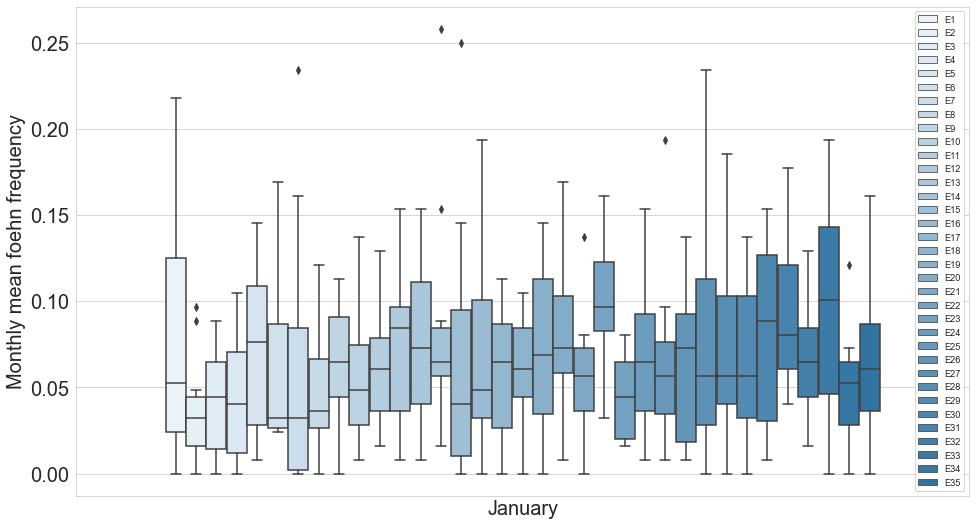

In [92]:
# Create a plot with all ensemble member distributions (10 years) for an given month
df_ensemble = df_foehn_ERA_CESMp_CESMf.loc[df_foehn_ERA_CESMp_CESMf["dataset"]=="CESMp"].groupby(["ensemble", "year", "month"], as_index=False).mean()
ax = sns.boxplot(x="month", y="prediction", data=df_ensemble.loc[df_ensemble["month"]==1,:], hue="ensemble", hue_order=["E"+str(i) for i in range(1,35+1)], color="tab:blue")
ax.set(xticks=[])
ax.set_xlabel("January")
ax.set_ylabel("Monthly mean foehn frequency")
ax.legend(fontsize=9.25)
save_figure(f"final_comparison_ensembles_{foehn_type[location]}")

# Plot composite maps

In [213]:
df_ERA_raw_temp_adjusted = df_ERA_raw.copy()

temp_columns = df_ERA_raw_temp_adjusted.filter(regex="T_").columns
df_ERA_raw_temp_adjusted[temp_columns] = df_ERA_raw_temp_adjusted[temp_columns]+ 273.15
df_ERA_with_stability = pd.concat([df_ERA_raw_temp_adjusted, calculate_stability(df = df_ERA_raw_temp_adjusted, lats = LATS_CESM_STRING, lons = LONS_CESM_STRING)], axis=1)

df_ERA_with_stability = pd.merge(df_foehn_raw, df_ERA_with_stability, on="date", how="inner")

In [214]:
variable ='U'

variable_lvl = {"SLP": "sealevel",
                "Z": "850",
                "T": "850",
                "DELTAPHI": "700",
                "U": "700",
                "V": "700"}

unit = {"SLP": "hPa",
        "Z": "meters",
        "T": "K",
        "DELTAPHI": "K",
        "U": "m/s",
        "V": "m/s"}

if location == "ALT":
    v_limits = {"SLP": [1002, 1023],
                "Z": [1360, 1570],
                "T": [3+273, 10.5+273],
                "DELTAPHI": [5,12],
                "U":[5,15],
                "V":[5,15]}
elif location == "LUG":
    v_limits = {"SLP": [1009, 1027.5],#[1003, 1018],
                "Z": [1420, 1581],#[1350, 1520],
                "T": [-3+273, 7.05+273],
                "DELTAPHI": [4, 14.05], #[6,11],
                "U":[5,15],
                "V":[5,15]}
    

# # Piotta
# v_limits = {"SLP": [1013, 1025],#[1003, 1018],
#             "Z": [1460, 1530],#[1350, 1520],
#             "T": [-1+273.15, 6+273.15],
#             "DELTAPHI": [5.5, 12.5], #[6,11],
#             "U":[5,15],
#             "V":[5,15]}

In [215]:
df_importances= generate_coordinates_from_feature_label(most_important_features, variable)

df_importances.sort_values(by="importance", ascending=False)

,variable,lat1,lon1,importance
0,V,4476,625,873.483039
1,V,4476,875,780.315645
3,V,4759,1375,413.389117
2,V,4664,1375,327.802958
4,V,4759,125,96.606196


In [216]:
df_ERA_reduced_features_scaled["false_positive"] = (df_ERA_reduced_features_scaled["prediction"] ==1) & (df_ERA_reduced_features_scaled["Foehn"] == 0)
df_ERA_reduced_features_scaled["false_negative"] = (df_ERA_reduced_features_scaled["prediction"] ==0) & (df_ERA_reduced_features_scaled["Foehn"] == 1)

U
Saved figure at: /home/chmony/Documents/Results/newgradient/SLP_composite_NorthFoehn.pdf'


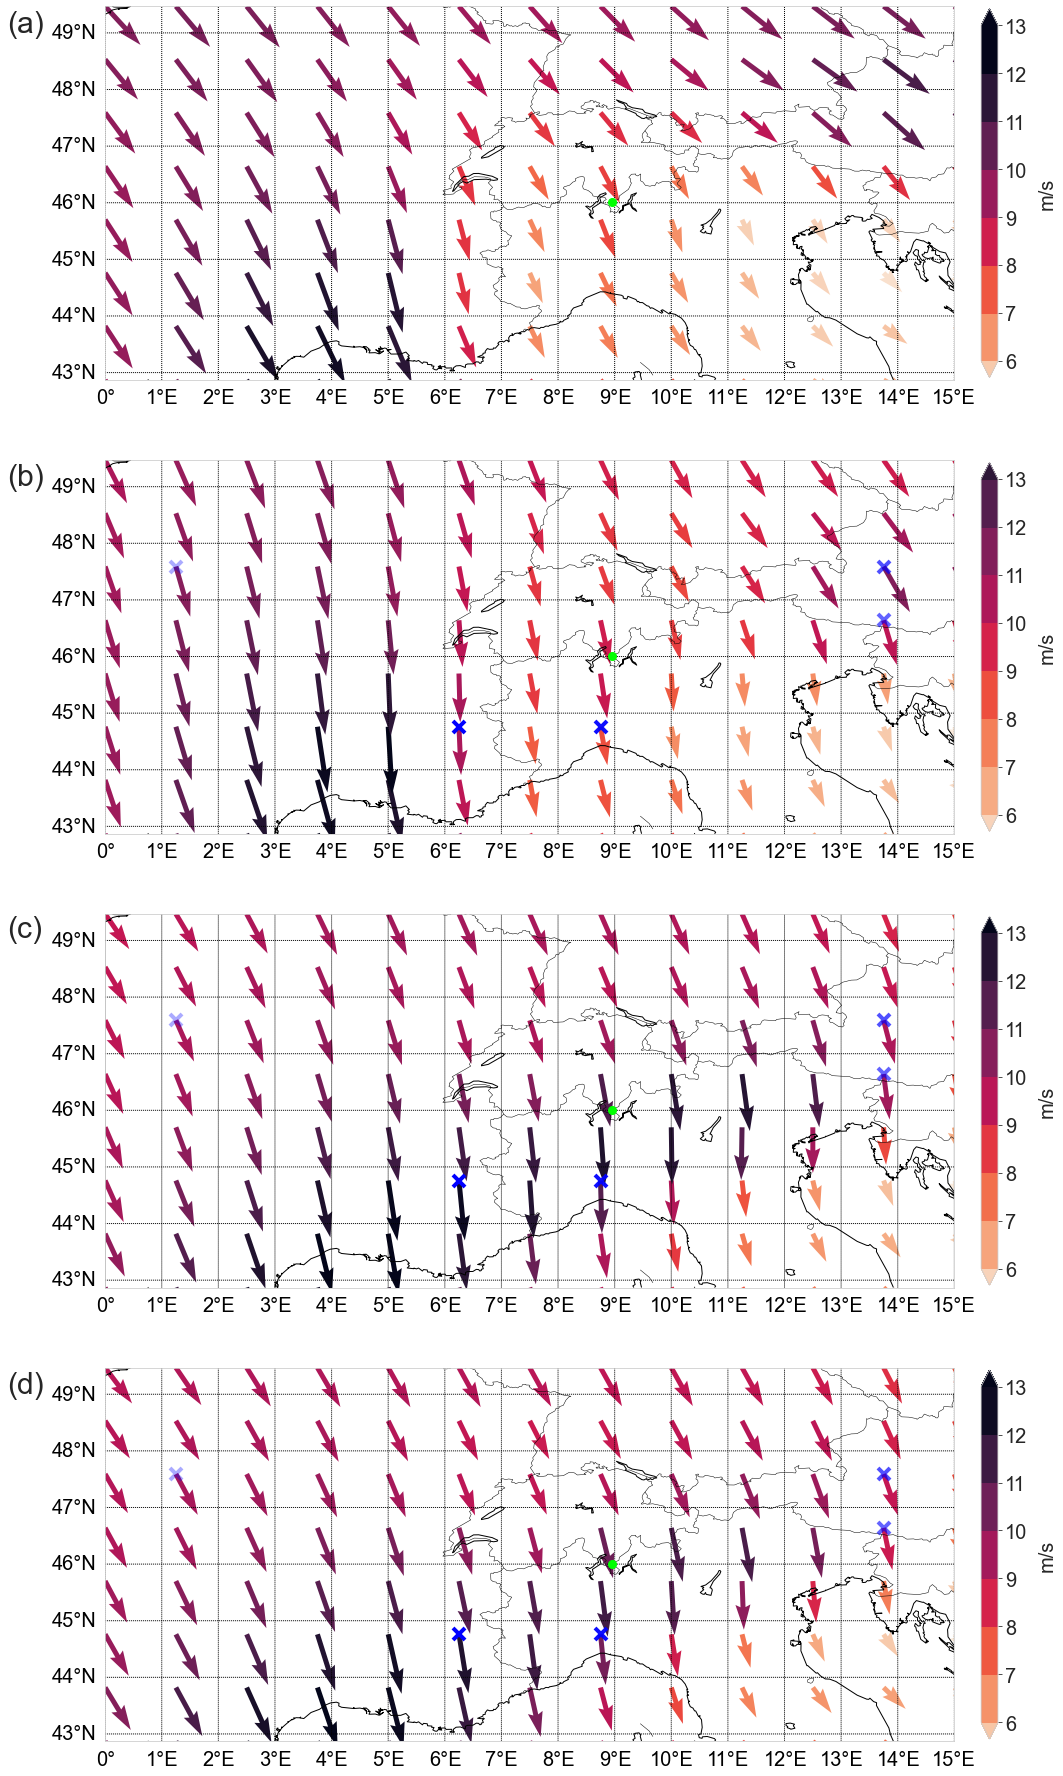

In [217]:
# Make composite plots
for variable in list(variable_lvl.keys())[-2:-1]:
    print(variable)
    df_importances = generate_coordinates_from_feature_label(most_important_features, variable)
    df_importances["importance"] = np.sqrt(df_importances["importance"])
    
    kwargs = {"variable": variable,
          "variable_lvl": variable_lvl[variable],
          "unit": unit[variable],
          "vmin": v_limits[variable][0],
          "vmax": v_limits[variable][1],
          "lats_labels": LATS_CESM_STRING, 
          "lons_labels": LONS_CESM_STRING, 
          "df_importances": pd.DataFrame(),
          "location": location}
    
    # OBS
    fig = plt.figure(figsize=(16, 4*8))
    fig.add_subplot(411)
    fig.text(0.04,0.868, "(a)", size=30, ha="left")
    

    plot_mean_foehn_condition_for_one_model(**kwargs, 
                                            model= f"OBS_{foehn_type[location]}", 
                                            df = df_ERA_with_stability.loc[test_mask,:], 
                                            foehn = df_ERA_reduced_features_scaled.loc[test_mask, "false_negative"], 
                                            )
    
    
    kwargs.update({"df_importances": df_importances})
    # ERAI
    fig.add_subplot(412)
    fig.text(0.04,0.671, "(b)", size=30, ha="left")
    plot_mean_foehn_condition_for_one_model(**kwargs,
                                            model= f"ERA-Interim_{foehn_type[location]}",
                                            df = df_ERA_with_stability.loc[test_mask,:], 
                                            foehn = df_ERA_reduced_features_scaled.loc[test_mask, "prediction"], 
                                            )

    # CESM-p
    fig.add_subplot(413)
    fig.text(0.04,0.475, "(c)", size=30, ha="left")
    plot_mean_foehn_condition_for_one_model(**kwargs, 
                                            model= f"CESM-present_{foehn_type[location]}", 
                                            df = df_CESMp.loc[:,:], 
                                            foehn = df_CESMp_reduced_features_scaled.loc[:, "prediction"], 
                                            )
    # CESM-f
    fig.add_subplot(414)
    fig.text(0.04,0.277, "(d)", size=30, ha="left")
    if variable =="T":
        kwargs["vmin"] += 3.5
        kwargs["vmax"] += 3.5
    plot_mean_foehn_condition_for_one_model(**kwargs, 
                                            model= f"CESM-future_{foehn_type[location]}",
                                            df = df_CESMf.loc[:,:], 
                                            foehn = df_CESMf_reduced_features_scaled.loc[:, "prediction"], 
                                            )
    #plt.savefig(f'/home/chmony/Documents/Results/newgradient/SLP_composite_{foehn_type[location]}.pdf', bbox_inches='tight', dpi=200)
    print(f"Saved figure at: /home/chmony/Documents/Results/newgradient/SLP_composite_{foehn_type[location]}.pdf'")
    

Saved figure at: /home/chmony/Documents/Results/newgradient/SLP_composite_NorthFoehn_FP_FN.pdf'


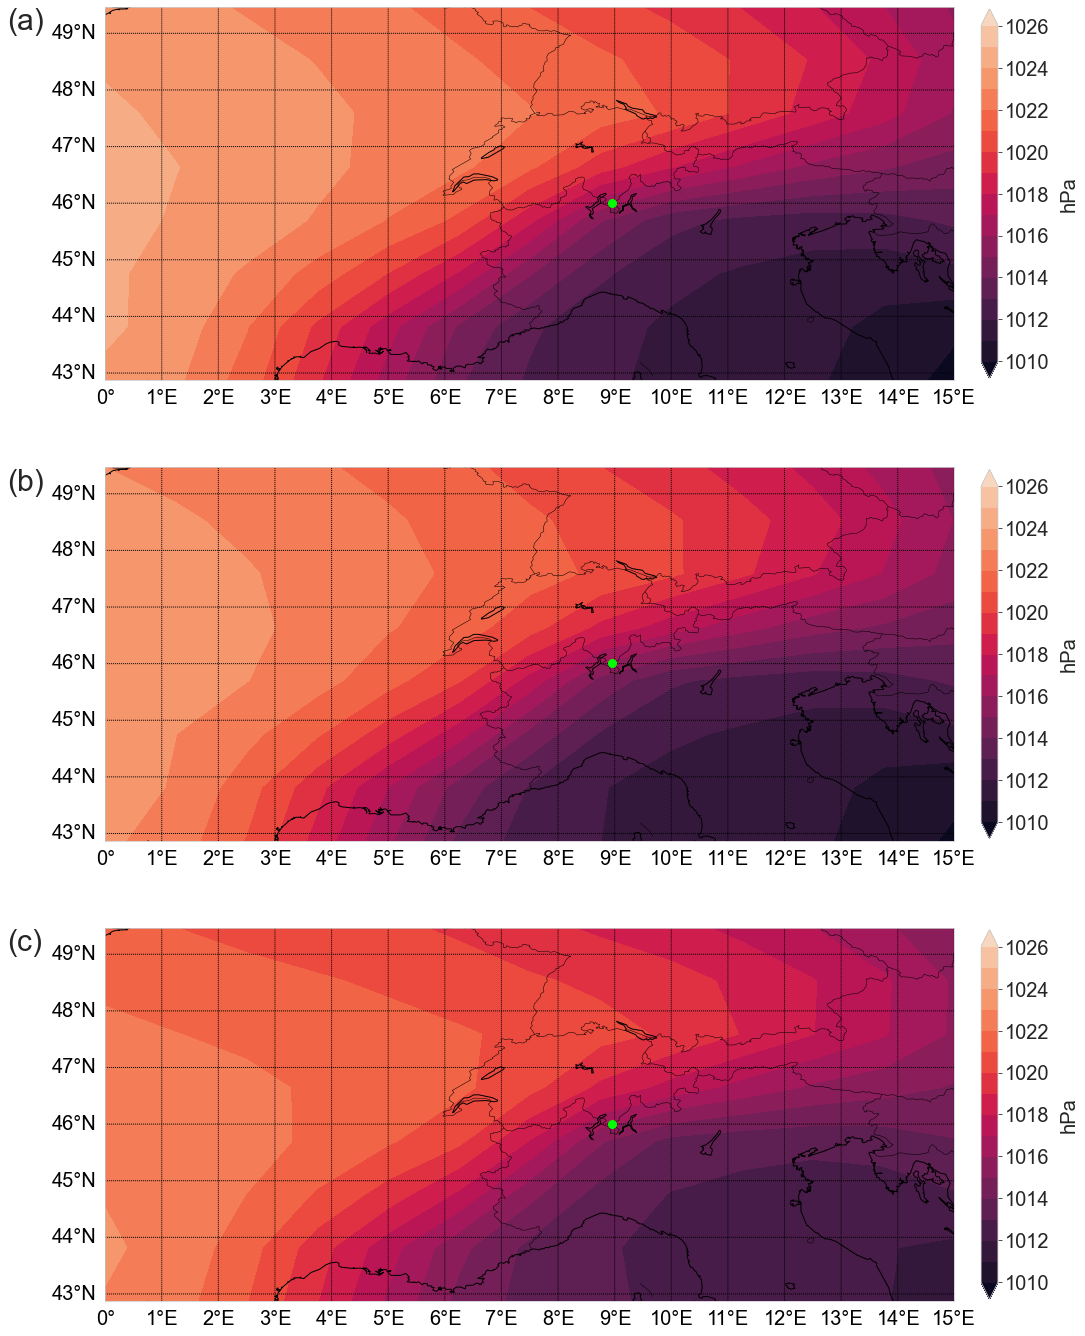

In [218]:
variable="SLP"
kwargs = {"variable": variable,
          "variable_lvl": variable_lvl[variable],
          "unit": unit[variable],
          "vmin": v_limits[variable][0],
          "vmax": v_limits[variable][1],
          "lats_labels": LATS_CESM_STRING, 
          "lons_labels": LONS_CESM_STRING, 
          "df_importances": pd.DataFrame(),
          "location": location}
    
# OBS
fig = plt.figure(figsize=(16, 3*8))
fig.add_subplot(311)
fig.text(0.04,0.864, "(a)", size=30, ha="left")

plot_mean_foehn_condition_for_one_model(**kwargs, 
                                        model= f"OBS_{foehn_type[location]}", 
                                        df = df_ERA_with_stability.loc[test_mask,:], 
                                        foehn = df_ERA_reduced_features_scaled.loc[test_mask, "Foehn"], 
                                        )

fig.add_subplot(312)
fig.text(0.04,0.597, "(b)", size=30, ha="left")

plot_mean_foehn_condition_for_one_model(**kwargs, 
                                        model= f"OBS_{foehn_type[location]}", 
                                        df = df_ERA_with_stability.loc[test_mask,:], 
                                        foehn = df_ERA_reduced_features_scaled.loc[test_mask, "false_positive"], 
                                        )

fig.add_subplot(313)
fig.text(0.04,0.331, "(c)", size=30, ha="left")

plot_mean_foehn_condition_for_one_model(**kwargs, 
                                        model= f"OBS_{foehn_type[location]}", 
                                        df = df_ERA_with_stability.loc[test_mask,:], 
                                        foehn = df_ERA_reduced_features_scaled.loc[test_mask, "false_negative"], 
                                        )

plt.savefig(f'/home/chmony/Documents/Results/newgradient/SLP_composite_{foehn_type[location]}_FP_FN.pdf', bbox_inches='tight', dpi=200)
print(f"Saved figure at: /home/chmony/Documents/Results/newgradient/SLP_composite_{foehn_type[location]}_FP_FN.pdf'")